# Small-world networks

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

The *small-world phenomenon* is, broadly speaking, the observation that any two people in a group can be connected by a surprisingly short path of acquaintances. This concept appears in the "Bacon number" game, where actors are nodes, appearing in the same movie creates an edge between them, and one tries to find the distance between Kevin Bacon and some other designated actor. 

In network science, there are two type of measurements used to quantify the effect: distance and clustering.

## Distance

The **distance** between two nodes in a connected graph is the number of edges in the shortest path between them. In a complete graph, the distance between any pair of distinct nodes is 1, since all possible pairs are connected by an edge.

In [2]:
K5 = nx.complete_graph(5)
dist = [ nx.shortest_path_length(K5,0,i) for i in K5.nodes ]
print("Distance from node 0:",dist)

Distance from node 0: [0, 1, 1, 1, 1]


The maximum distance over all pairs of nodes in a graph is called its **diameter**. Since this value depends on an extreme outlier in the degree distribution, it is often preferred to use the **average distance** as a measure of how difficult it is to connect two randomly selected nodes.

For example, here is a *wheel graph*:

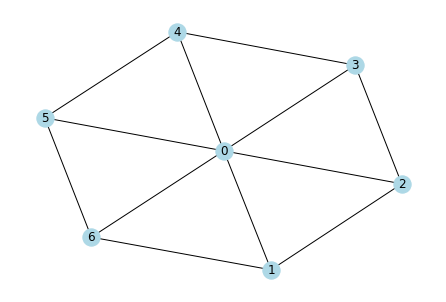

In [3]:
W = nx.wheel_graph(7)
nx.draw(W,with_labels=True,node_color="lightblue")

No node is more than two hops away from another, if the first hop is to node 0, so the diameter of this graph is 2. The average distance is somewhat smaller. This graph is so small that we can easily find the entire matrix of pairwise distances.

In [4]:
nodes = list(W.nodes)
n = len(nodes)
D = np.zeros((n,n),dtype=int)
for i in range(n):
    for j in range(i+1,n):
        D[i,j] = nx.shortest_path_length(W,nodes[i],nodes[j]) 

print(D)

[[0 1 1 1 1 1 1]
 [0 0 1 2 2 2 1]
 [0 0 0 1 2 2 2]
 [0 0 0 0 1 2 2]
 [0 0 0 0 0 1 2]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


The actual distance matrix is symmetric, but it's only necessary to compute its upper triangle. To get the average distance, we can sum over all the entries and divide by $\binom{n}{2}$:

In [5]:
print("average distance:",2*D.sum()/(n*(n-1)))

average distance: 1.4285714285714286


There is a convenience function for computing this average. (It becomes slow as $n$ grows, though.)

In [6]:
print("average distance:",nx.average_shortest_path_length(W))

average distance: 1.4285714285714286


## Clustering

Intuitively, the idea behind clustering is that your friends tend to be friends of one another. There are various ways to quantify this precisely, but the easiest is the **local clustering coefficient**, defined for a node $i$ as

$$
C(i) = \frac{ 2 T(i) }{d_i(d_i-1)}.
$$

In this formula, $d_i$ is the degree of the node and $T(i)$ is the number of edges between node $i$'s neighbors. Equivalently, $T(i)$ is the number of triangles in the graph that pass through node $i$. Because the subgraph of the friend nodes has

$$
\binom{d_i}{2}
$$

possible edges, the maximum of $C(i)$ is 1.

::::{prf:example}
:label: example-small-world-clustering
Find the clustering coefficient for each node in the wheel graph drawn above.
:::{dropdown} Solution
Node 0 in this graph is adjacent to 6 other nodes, and there are 6 triangles passing through it. Thus, its clustering coefficient is

$$
C(0) = \frac{6}{6 \cdot 5 / 2} = \frac{2}{5}.
$$

Every other node has 3 friends and 2 triangles, so they each have

$$
C(i) = \frac{2}{3 \cdot 2 / 2} = \frac{2}{3}, \quad i\neq 0.
$$
:::
::::

In NetworkX, we can manually count the number of edges among neighbors of node 0 by examining their subgraph:

In [7]:
nbrhood = W.subgraph(W[1])
print(nbrhood.number_of_edges(),"edges among neighbors of node 1")

2 edges among neighbors of node 1


More directly, though, the `clustering` function in NetworkX computes $C(i)$ for any single node, or for all the nodes in a graph.

In [8]:
print("node 0 clustering:",nx.clustering(W,0))
print("\nall nodes clustering:")
print(pd.Series(nx.clustering(W),index=W.nodes))

node 0 clustering: 0.4

all nodes clustering:
0    0.400000
1    0.666667
2    0.666667
3    0.666667
4    0.666667
5    0.666667
6    0.666667
dtype: float64


## ER graphs

If we want to compute distance and clustering within ER random graphs, we quickly run into a problem: an ER graph may not have a path between every pair of nodes. We say that such a graph is not **connected**.

In [9]:
n,p = 101,1/25
ER = nx.erdos_renyi_graph(n,p,seed=0)
nx.is_connected(ER)

False

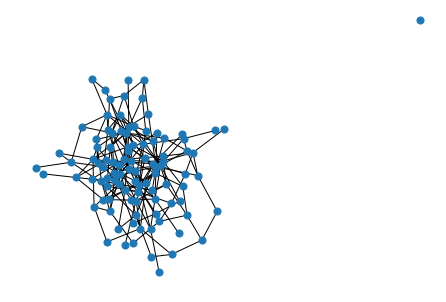

In [10]:
nx.draw(ER,node_size=50)

When no path exists between two nodes, the only sensible definition of distance is infinity, and averages that include infinity are themselves infinite. In fact, NetworkX will give an error if we try to compute the average distance in a disconnected graph:

In [11]:
nx.average_shortest_path_length(ER)

NetworkXError: Graph is not connected.

We are also unable to compute the clustering coefficient at a node of degree zero.

One way to cope with this eventuality is to decompose the graph into **connected components**, a disjoint separation of the nodes into connected subgraphs. We can use `nx.connected_components` to get node sets for each component.

In [12]:
[len(cc) for cc in nx.connected_components(ER)]

[100, 1]

The result above tells us that removing the lone unconnected node in the ER graph leaves us with a connected component. We can always get the largest component with the following:

In [13]:
ER_sub = ER.subgraph( max(nx.connected_components(ER), key=len) )
print(ER_sub.number_of_nodes(),"nodes in largest component")

100 nodes in largest component


Now the average path length is a valid computation.

In [14]:
nx.average_shortest_path_length(ER_sub)

3.3082828282828283

Let's cut a little slack at this point and compute the distance and clustering for those ER graphs which happen to be connected.

average distances in the largest component:


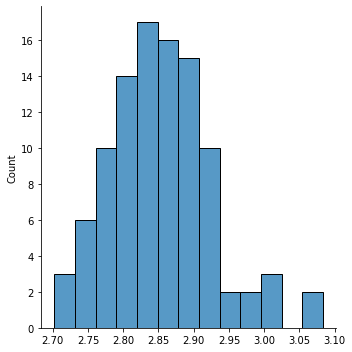

In [15]:
n,p = 121,1/20
dbar,cbar = [],[]
for iter in range(100):
    ER = nx.erdos_renyi_graph(n,p,seed=iter+5000)
    ER_sub = ER.subgraph( max(nx.connected_components(ER), key=len) )
    dbar.append(nx.average_shortest_path_length(ER_sub))
    cbar.append(nx.average_clustering(ER_sub))        

print("average distances in the largest component:")
sns.displot(x=dbar,bins=13);

The chances are good that any message could be passed along in three hops or fewer. In fact, theory states that as $n\to\infty$, the mean distance in ER graphs is expected to be approximately 

```{math}
:label: eq-small-world-ERdistance
\frac{\ln(n)}{\ln(\bar{k})}.
```

For $n=121$ and $\bar{k}=6$ as in the experiment above, this value is about 2.68.

Meanwhile, the local clustering in these ER graphs is close to zero:

average clustering:


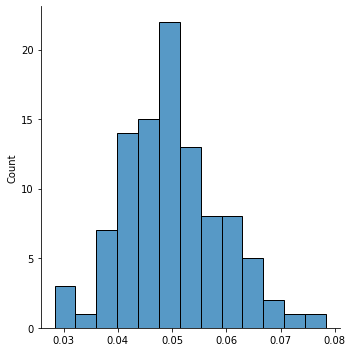

In [16]:
print("average clustering:")
sns.displot(x=cbar,bins=13);

This happens because there is no special affinity for friendship among one's friends. Since every edge appears with probability $p$, the expected fraction of edges in the ego network of a node is also $p$, and that is the expected value for the clustering coefficient at each node as well.

## Twitch network

Let's consider the Twitch network again.

In [17]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)
n,e = twitch.number_of_nodes(),twitch.number_of_edges()
kbar = 2*e/n
print(n,"nodes and",e,"edges")
print(f"average degree is {kbar:.3f}")

7126 nodes and 35324 edges
average degree is 9.914


Computing the distances between all pairs of nodes in this graph would take a rather long time, so we will estimate the average distance by sampling.

In [18]:
from numpy.random import default_rng
rng = default_rng(1)

# Compute the distance between a random pair of distinct nodes:
def pairdist(G):
    n = nx.number_of_nodes(G)
    i = j = rng.integers(0,n)
    while i==j: j=rng.integers(0,n)   # get distinct nodes
    return nx.shortest_path_length(G,source=i,target=j)

distances = pd.Series([pairdist(twitch) for _ in range(100000)])

print("For Twitch graph...")
print("Distribution of distance samples:")
print(distances.value_counts())
print("\nEstimated mean distance:",distances.mean())

For Twitch graph...
Distribution of distance samples:
4    42813
3    36231
5    12570
2     6294
6     1724
7      191
1      159
8       17
9        1
dtype: int64

Estimated mean distance: 3.67368


Here are the clustering coefficients:

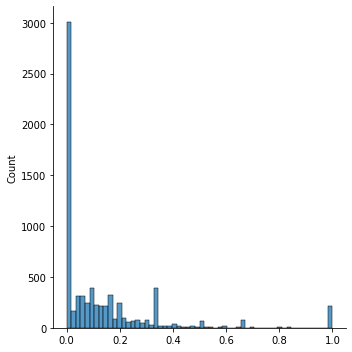

In [19]:
cluster_coeffs = pd.Series(nx.clustering(twitch),index=twitch.nodes)
sns.displot(data=cluster_coeffs);

In [20]:
cluster_coeffs.describe()

count    7126.000000
mean        0.130928
std         0.206261
min         0.000000
25%         0.000000
50%         0.057143
75%         0.166667
max         1.000000
dtype: float64

Let's compare these results to ER graphs with the same size and average degree, implying $p=\bar{k}/(n-1)$. It's time-consuming to sample enough graphs to be statistically meaningful, so we do just a few here to get a taste.

In [21]:
p = kbar/(n-1)

dbar,cbar = [],[]
for iter in range(4):
    ER = nx.erdos_renyi_graph(n,p,seed=iter+789)
    ER_sub = ER.subgraph( max(nx.connected_components(ER), key=len) )
    dist = [pairdist(ER_sub) for _ in range(80)]
    dbar.append(np.mean(dist))
    cbar.append(nx.average_clustering(ER_sub))        

print("For ER graphs:")
print("Average of mean distance:",np.mean(dbar))
print("Average of mean clustering:",np.mean(cbar))

For ER graphs:
Average of mean distance: 4.1125
Average of mean clustering: 0.0014539580305994474


Equation {eq}`eq-small-world-ERdistance`, applied with $n$ and $\bar{k}$ from the Twitch network, predicts a mean distance of

In [22]:
print("ER graphs mean distance:",np.log(n)/np.log(kbar))

ER graphs mean distance: 3.8673326382368893


This value is a bit smaller than the one observed above, but in any case, the values are not much different from those for the Twitch network. 

Unlike the Twitch network, though, ER graphs show essentially no local clustering. This was true experimentally above, and the theoretical expected value is $p\approx 0.0014.$ It's clear that the Twitch social network has a much greater likelihood of "my friends are also friends of each other" than a random ER graph has.

## Watts–Strogatz graphs

A **Watts–Strogatz graph** (WS graph) tries to model the small-world phenomenon. A WS graph has three parameters: $n$, an even integer $k$, and a probability $q$. 

Imagine $n$ nodes arranged in a circle. Connect each node with an edge to each of its $k/2$ left neighbors and $k/2$ right neighbors. Now visit each node $i$ in turn. For each edge from $i$ to a neighbor, with probability $q$ replace it with an edge between $i$ and a node chosen at random from all the nodes $i$ is not currently connected to. The idea is to start with tight-knit, overlapping communities, and randomly toss in some far-flung links.

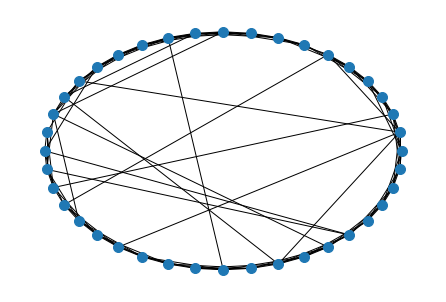

In [23]:
WS = nx.watts_strogatz_graph(40,6,0.15,seed=1)
nx.draw_circular(WS,node_size=100)

For $q<1$, a WS graph has a mean clustering coefficient that is significantly above zero.

In [24]:
n,k = 60,6
results = pd.DataFrame({"q":[],"mean cluster":[]})
seed = 0
for q in np.arange(0.05,1.05,0.05):
    cbar = []
    for iter in range(50):
        WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
        cbar.append(nx.average_clustering(WS))
        seed += 1
    results = pd.concat((results,
                         pd.DataFrame({"q":q,"mean cluster":cbar})),
                        ignore_index=True)

Mean clustering in WS graphs on 60 nodes:


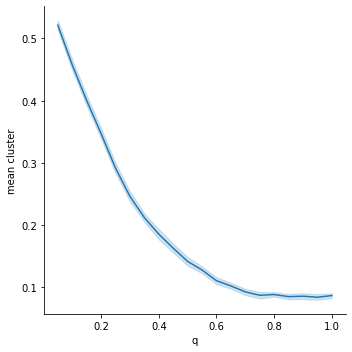

In [25]:
print("Mean clustering in WS graphs on 60 nodes:")
sns.relplot(data=results,x="q",y="mean cluster",kind="line");

Let's scale the experiment up to the size of the Twitch network.

In [26]:
results = pd.DataFrame({"q":[],"mean cluster":[]})
seed = 0
n,k = twitch.number_of_nodes(),10
for q in np.arange(0.05,1,0.1):
    cbar = []
    for iter in range(6):
        WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
        cbar.append(nx.average_clustering(WS))
        seed += 1
    results = pd.concat((results,
                         pd.DataFrame({"q":q,"mean cluster":cbar})),
                        ignore_index=True)

Mean clustering in WS graphs on 7126 nodes:


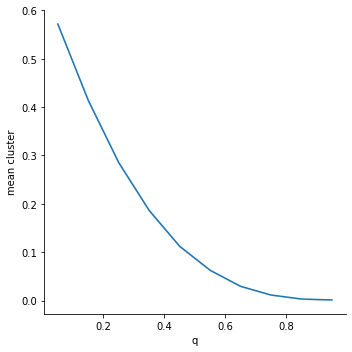

In [27]:
print("Mean clustering in WS graphs on",n,"nodes:")
sns.relplot(data=results,x="q",y="mean cluster",kind="line");

The mean clustering resembles the value of 0.13 for the Twitch network at around $q=0.4$. However, that leaves the mean distance a bit too large:

In [28]:
results = pd.DataFrame({"q":[],"mean distance":[]})
seed = 0
n,k,q = twitch.number_of_nodes(),10,0.4
for iter in range(30):
    WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
    d = sum(pairdist(WS) for _ in range(100))
    dbar.append(d/100)
    seed += 1
print("mean distance in WS:",np.mean(dbar))

mean distance in WS: 4.404411764705882


At this point it's inconclusive whether the WS construction can explain the Twitch network. In the next section, we will see that it is lacking in at least one other important way.